In [23]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.tri import Triangulation

from matplotlib.patches import Rectangle

Specify the directory and filename:

In [24]:
data_dir = '../../../raw_data/'

In [25]:
#Currently: Regionally-Refined, 01/01/2010
file='rr_extracted_for_bas_FWmaHIST_ne0CONUSne30x8_ne0CONUSne30x8_mt12_no_conus_gravity_waves.cam.h0.2010-01-01-00000.nc'

Read in the dataset

In [26]:
ds = xr.open_dataset(data_dir+file)

In [27]:
# inspect
ds

<xarray.Dataset> Size: 7GB
Dimensions:    (time: 24, lev: 110, ncol: 174098, ilev: 111, nbnd: 2)
Coordinates:
  * ilev       (ilev) float64 888B 4.949e-06 7.618e-06 1.173e-05 ... 985.1 1e+03
  * lev        (lev) float64 880B 6.14e-06 9.453e-06 1.455e-05 ... 976.3 992.6
  * time       (time) object 192B 2010-01-01 00:00:00 ... 2010-01-01 23:00:00
Dimensions without coordinates: ncol, nbnd
Data variables:
    OMEGA      (time, lev, ncol) float32 2GB ...
    T          (time, lev, ncol) float32 2GB ...
    U          (time, lev, ncol) float32 2GB ...
    V          (time, lev, ncol) float32 2GB ...
    area       (ncol) float64 1MB ...
    lat        (ncol) float64 1MB ...
    lon        (ncol) float64 1MB ...
    time_bnds  (time, nbnd) object 384B ...
Attributes: (12/13)
    ne:                0
    np:                4
    Conventions:       CF-1.0
    source:            CAM
    case:              FWmaHIST_ne0CONUSne30x8_ne0CONUSne30x8_mt12_no_conus_g...
    logname:           nadavis
    ...                ...
    initial_file:      /glade/p/cgd/amp/pel/inic/waccm-conus-FW-nlev110.i.nc
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/se/ne30x...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1
    history:           Thu Nov 14 16:31:50 2024: ncks -v T,U,V,OMEGA,lat,lon,...
    NCO:               netCDF Operators version 5.1.9 (Homepage = http://nco....

In [28]:
vars = ['lat',
        'lon',
        'area',#Area of the grid point (for weighted means)
        'OMEGA', #Vertical velocity in Pa s-1
        'T',
        'U',
        'V'
       ]

# Extract a pressure range for the required variables
ds1  = ds[vars].isel(lev=slice(3,23))

ds.close() #close the original dataset

Read in lat and lon values to create the grid for plotting

In [29]:
#extract dimension data
x=ds1['lon'].data
y=ds1['lat'].data

#For a rough visualisation of data on the unstructured grid:
tri = Triangulation(x, y)

A value, q, can be expressed as the sum of the mean value and the variance from the mean:  
$q$ = $\overline{q}$ + $q'$

Therefore for temperature and  zonal and meridional winds, variances are given by:  
$T'$ = $T$ - $\overline{T}$  
$U'$ = $U$ - $\overline{U}$  
$V'$ = $V$ - $\overline{V}$

In [30]:
#Compute primes
tprime = (ds1.T - ds1.T.mean(dim='time')).compute()
uprime = (ds1.U - ds1.U.mean(dim='time')).compute()
vprime = (ds1.V - ds1.V.mean(dim='time')).compute()

Vertical transport, w, is calculated from omega


Omega (ω) is vertical velocity in Pa s<sup>-1</sup>  

Ideal gas law: pV = nRT  
density ρ (kg m-3) = Mw*n/V  
p = ρ RT where R = ideal gas constant / mean molecular weight  
Δp = -ρgΔz  
ω = Δp/t, w = Δz/t  

ω = - rho g w 
w = - ω / ρ g

**w = - ω RT / p g (m s<sup>-1</sup>)**


In [31]:
R = 287.053 # J·K–1·kg–1
# /100 to convert from m s-1 to cm s-1
w = (-R * ds1.OMEGA * ds1.T / (100. * ds1.lev * 9.81)).compute() # TODO check units

In [32]:
#mean w value:
wbar = w.mean(dim='time')

Plotting wbar against ncol:

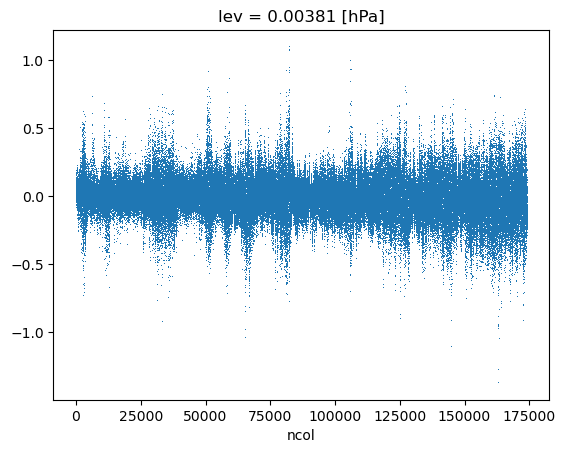

In [33]:
wbar.isel(lev=12).plot(marker=',',linestyle=' ')

In [34]:
#Compute w prime
wprime = w - wbar

### Temperature flux over the conus region:

In [35]:
#flux = mean(q'*w')
%time flux = (tprime*wprime).mean(dim='time')

CPU times: total: 812 ms
Wall time: 890 ms


In [36]:
#Limit to conus region only:
flux_conus = flux.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290))

Save temperature flux to a netcdf file:


In [37]:
#in the current directory
flux_conus.to_netcdf('flux_conus.nc')

### Plotting the results

CPU times: total: 2.41 s
Wall time: 2.62 s


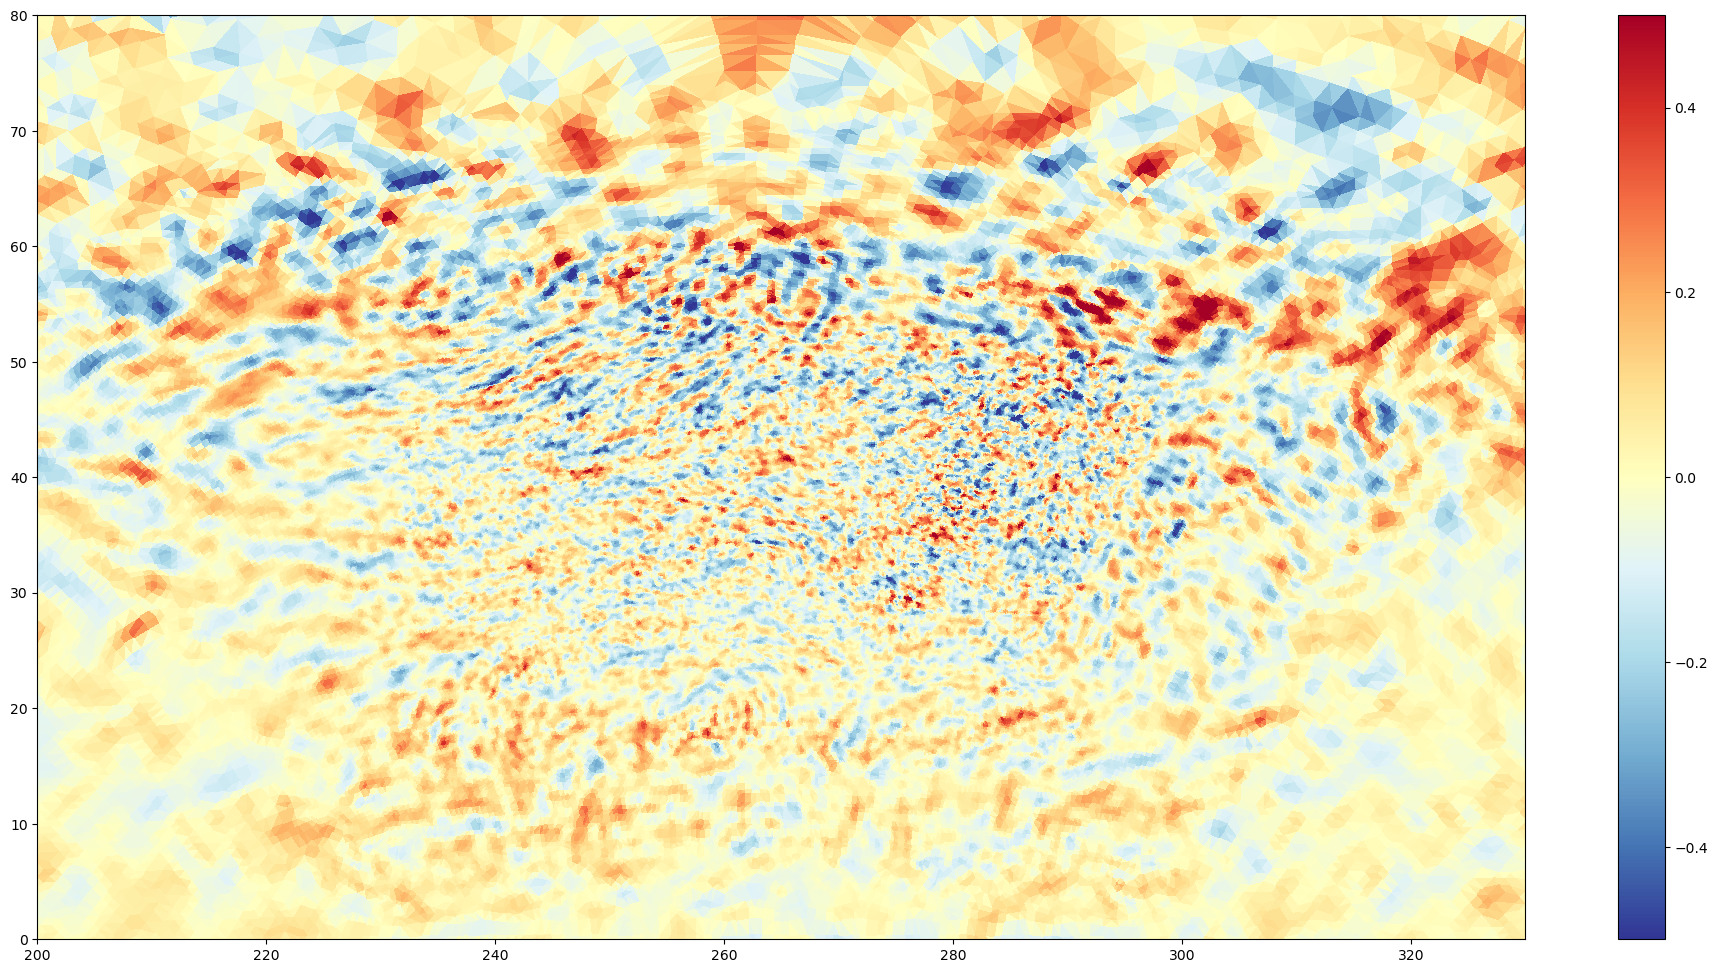

In [40]:
#Plotting wbar
fig = plt.figure(figsize=(24,12))

ax = plt.axes()

ax.set_xlim([200, 330])
ax.set_ylim([0,80])

%time im = ax.tripcolor(tri, wbar.isel(lev=12), shading = 'flat', vmin=-0.5, vmax=0.5, cmap='RdYlBu_r')

cb = plt.colorbar(im)

plt.show()

CPU times: total: 906 ms
Wall time: 1.61 s


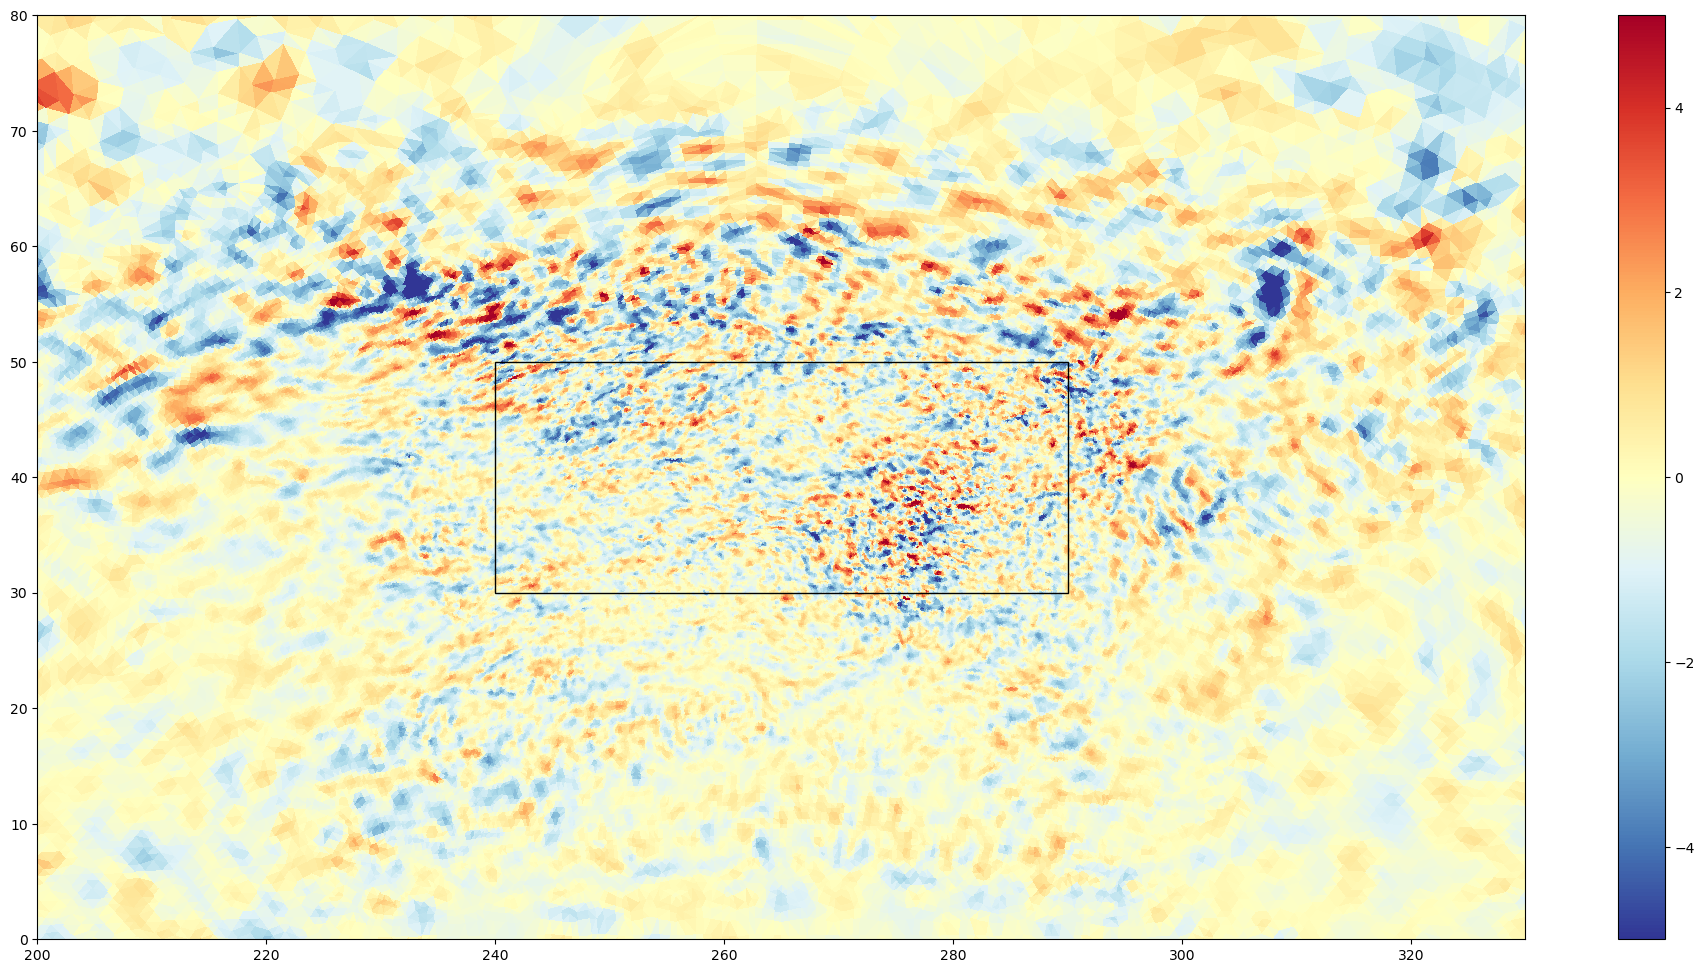

In [54]:
#Include a rectangle indicating the high resolution conus region
#Plotting T flux
fig = plt.figure(figsize=(24,12))

ax = plt.axes()

ax.set_xlim([200, 330])
ax.set_ylim([0,80])

%time im = ax.tripcolor(tri, flux.isel(lev=12), shading = 'flat', vmin=-5, vmax=5, cmap='RdYlBu_r')
#add rectangle to plot

ax.add_patch(Rectangle((240, 30), 50, 20, linestyle='-', fill = False))

cb = plt.colorbar(im)

plt.show()

CPU times: total: 766 ms
Wall time: 1.3 s


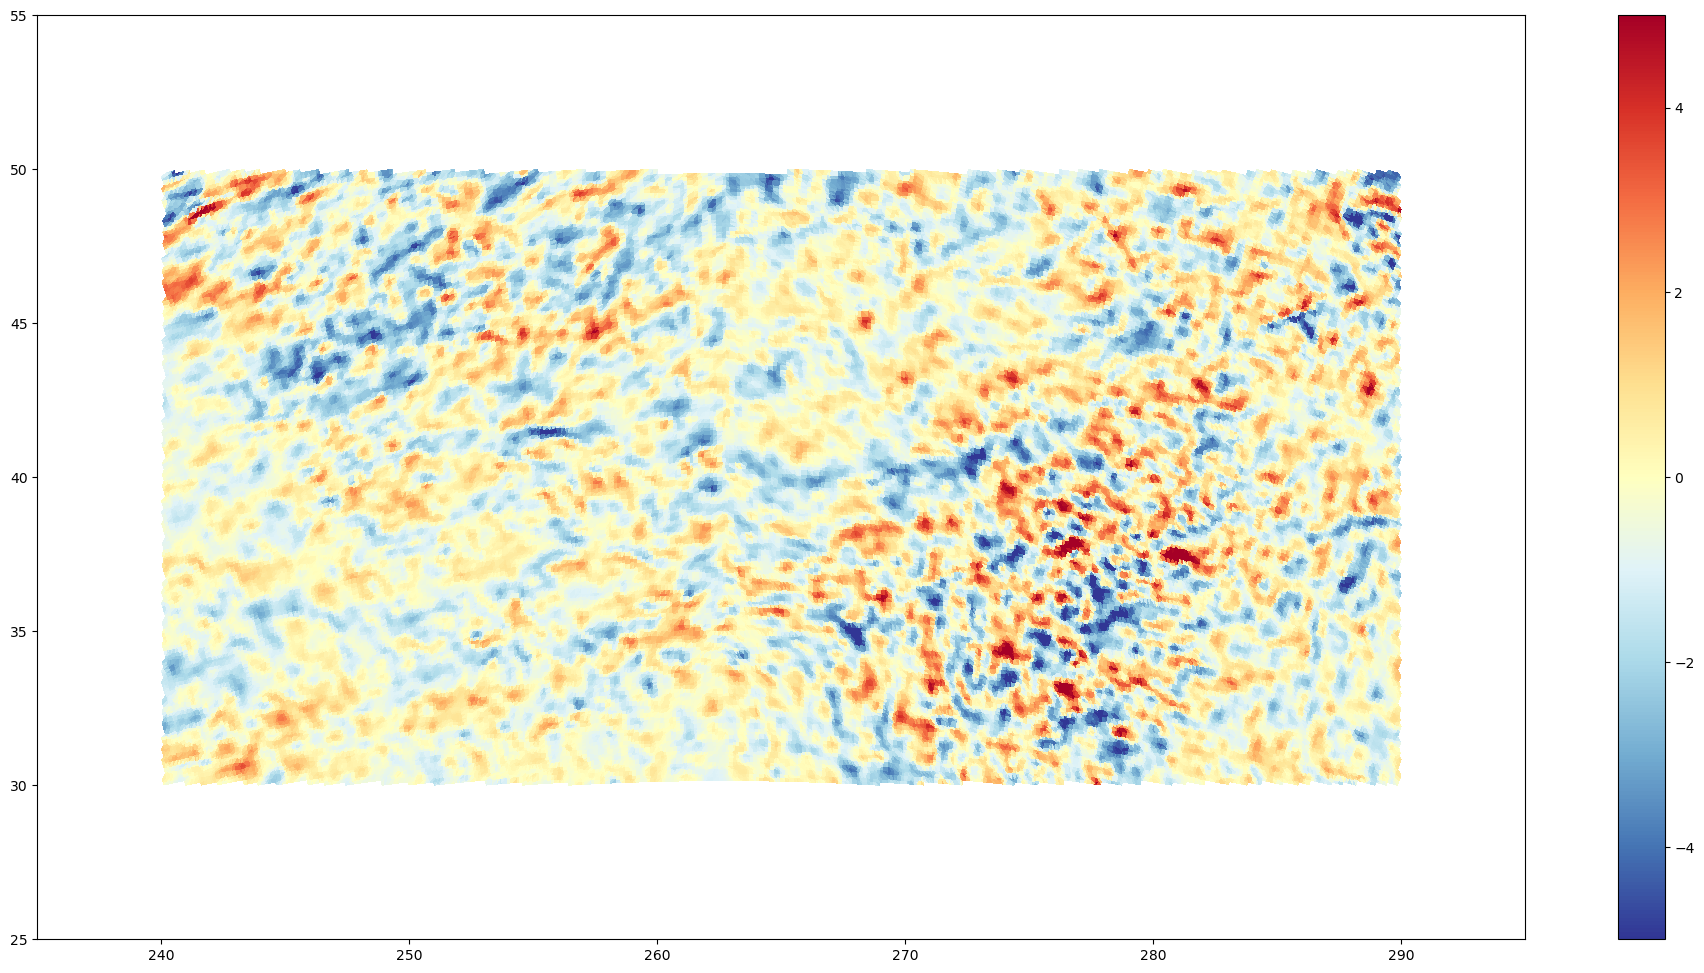

In [21]:
#Plotting T flux in the conus region only

fig = plt.figure(figsize=(24,12))

ax = plt.axes()

ax.set_xlim([235, 295])
ax.set_ylim([25,55])

%time im = ax.tripcolor(tri, flux_conus.isel(lev=12), shading = 'flat', vmin=-5, vmax=5, cmap='RdYlBu_r')

cb = plt.colorbar(im)

plt.show()

### Average heat flux over conus region

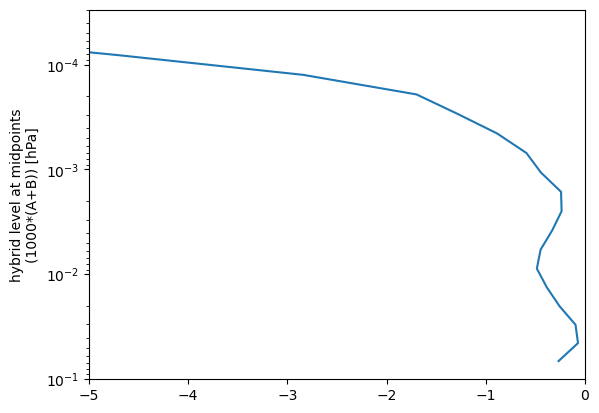

In [22]:
# SHOULD BE AN AREA-WEIGHTED MEAN! SEE last plots
# Unweighted mean temperature flux
flux_avg = flux_conus.mean(dim='ncol')
flux_avg.plot(y='lev', yscale='log', ylim=[0.1,.00003], xlim=[-5,0])

For averages, the values should be weighted by the area of the grid point  
This is usually done using cos(latitude), but this is not proportional to the area of the grid point on a cubed-sphere.  
Where available, 'area' should be used instead!

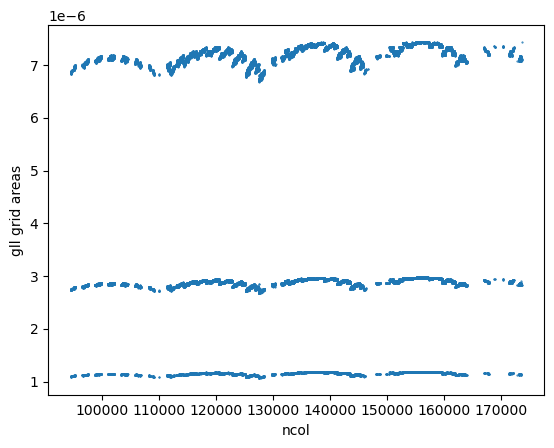

In [27]:
#using area for weighting
weights_conus = ds1.area.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290))
weights_conus.plot(linestyle=' ',marker='.',markersize=1)

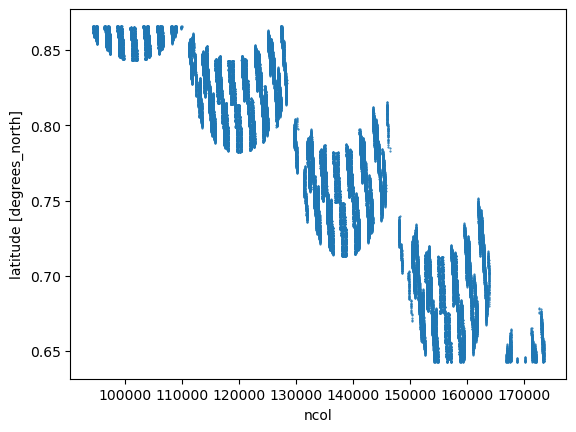

In [28]:
#using cos(latitude) for weighting
weights_conus2 = np.cos(np.deg2rad(ds1.lat).where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)))
weights_conus2.plot(linestyle='',marker='.',markersize=1)

In [29]:
#using cos(latitude) for the weights
wts2 = weights_conus2.dropna(dim='ncol')

In [30]:
#daily mean temperature 
tbar_conus = ds1.T.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).mean(dim=['time','ncol'])
tbar_conus_weighted = ds1.T.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').weighted(wts2).mean(dim=['time','ncol'])

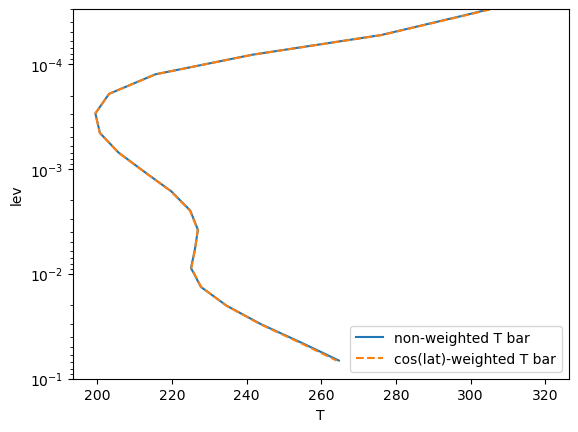

In [49]:
#Comparison with and without weighting
tbar_conus.plot(y='lev', yscale='log', ylim=[0.1,.00003],label='non-weighted T bar')
tbar_conus_weighted.plot(y='lev', yscale='log', ylim=[0.1,.00003],label='cos(lat)-weighted T bar',linestyle='dashed')
plt.legend()

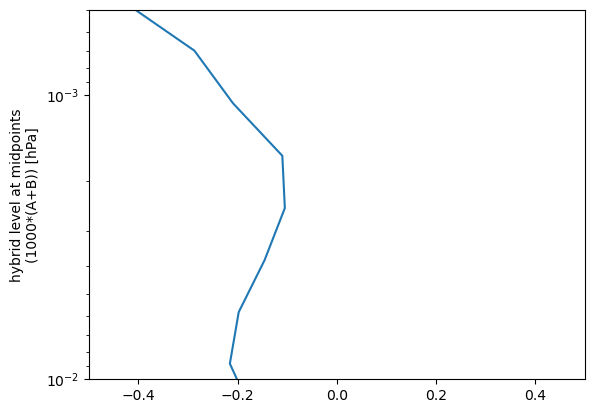

In [32]:
#wbar heat (cm/s)
#flux is currently UNWEIGHTED!
(flux_avg/tbar_conus*100.).plot(y='lev', yscale='log', ylim=[0.01,.0005], xlim=[-0.5,0.5])

In [37]:
#using 'where' returns NaN for values outside the parameters specified
print(flux_conus)
#Using .dropna removes these NaNs
flux_conus.dropna(dim='ncol')

<xarray.DataArray (lev: 20, ncol: 174098)> Size: 28MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lev      (lev) float64 160B 2.24e-05 3.447e-05 5.303e-05 ... 0.04518 0.06711
Dimensions without coordinates: ncol


<xarray.DataArray (lev: 20, ncol: 50298)> Size: 8MB
array([[ 1.16903933e+02,  6.61528480e+01,  1.12762510e+02, ...,
        -4.31840909e+00, -2.54696117e+01, -2.09819508e+01],
       [ 8.69830274e+01,  3.60108603e+01,  8.75226227e+01, ...,
        -1.38702057e+01, -1.51430261e+01, -1.14984494e+01],
       [ 3.96326945e+01,  6.26733158e+00,  4.78536168e+01, ...,
        -2.02448609e+01, -3.34326956e+00, -3.13329872e+01],
       ...,
       [ 4.40545342e-01,  5.36719880e-01,  2.15636732e-01, ...,
         2.19403783e-01, -1.77363272e+00, -3.44833436e-01],
       [-2.45269828e+00, -1.40339080e+00, -1.87956167e+00, ...,
        -2.13028578e+00, -2.08703739e+00,  9.57928257e-02],
       [-1.99922561e+00, -1.08259901e+00, -2.35519539e+00, ...,
        -6.01050844e-01, -1.15275647e-01, -3.34546335e-01]])
Coordinates:
  * lev      (lev) float64 160B 2.24e-05 3.447e-05 5.303e-05 ... 0.04518 0.06711
Dimensions without coordinates: ncol

In [38]:
# area weighting:
wts = weights_conus.dropna(dim='ncol')

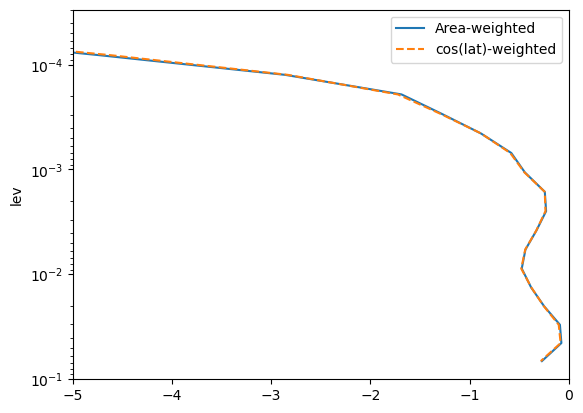

In [50]:
#Comparison of area and cos(lat) weighting
flux_avg1 = flux_conus.dropna(dim='ncol').weighted(wts).mean(dim='ncol')
flux_avg2 = flux_conus.dropna(dim='ncol').weighted(wts2).mean(dim='ncol')

flux_avg1.plot(y='lev', yscale='log', ylim=[0.1,.00003], xlim=[-5,0], label='Area-weighted')
flux_avg2.plot(y='lev', yscale='log', ylim=[0.1,.00003], xlim=[-5,0], label='cos(lat)-weighted',linestyle='dashed')

plt.legend()

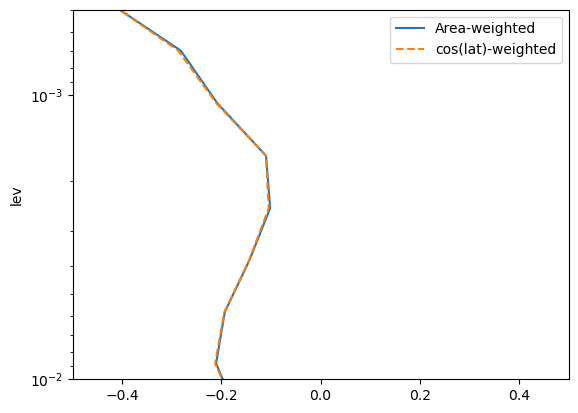

In [51]:
#wbar heat (cm/s)
(flux_avg1/tbar_conus*100.).plot(y='lev', yscale='log', ylim=[0.01,.0005], xlim=[-0.5,0.5], label='Area-weighted')
(flux_avg2/tbar_conus_weighted*100.).plot(y='lev', yscale='log', ylim=[0.01,.0005], xlim=[-0.5,0.5], label='cos(lat)-weighted',linestyle='dashed')
plt.legend()

In [52]:
# variances at nearest to 5e-3 hPa (~90 km, peak downward flux in the mesosphere)
print('var(T\')',(tprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=5e-03,method='nearest')**2).weighted(wts).mean(dim=('ncol','time')).data)
print('var(w\')',(wprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=5e-03,method='nearest')**2).weighted(wts).mean(dim=('ncol','time')).data)
print('var(U\')',(uprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=5e-03,method='nearest')**2).weighted(wts).mean(dim=('ncol','time')).data)
print('var(V\')',(vprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=5e-03,method='nearest')**2).weighted(wts).mean(dim=('ncol','time')).data)

var(T') 83.79747537522307
var(w') 0.539533822543473
var(U') 345.5157619577445
var(V') 392.33656077540024


In [53]:
# variance between 7e-4 and 1e-2 (~80 - 100km)
print('var(T\')',(tprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=slice(7e-4,1e-2))**2).weighted(wts).mean(dim=('ncol','time','lev')).data)
print('var(w\')',(wprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=slice(7e-4,1e-2))**2).weighted(wts).mean(dim=('ncol','time','lev')).data)
print('var(U\')',(uprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=slice(7e-4,1e-2))**2).weighted(wts).mean(dim=('ncol','time','lev')).data)
print('var(V\')',(vprime.where((y > 30.) & (y < 50.) & (x > 240.) & (x < 290)).dropna('ncol').sel(lev=slice(7e-4,1e-2))**2).weighted(wts).mean(dim=('ncol','time','lev')).data)

var(T') 78.30468566233492
var(w') 0.9781416553965613
var(U') 521.9552760766553
var(V') 666.1498217906825


Table 1 from Gardner and Liu (2007) - Seasonal variations of the vertical fluxes of heat and horizontal momentum in the mesopause region at Starfire Optical Range, New Mexico
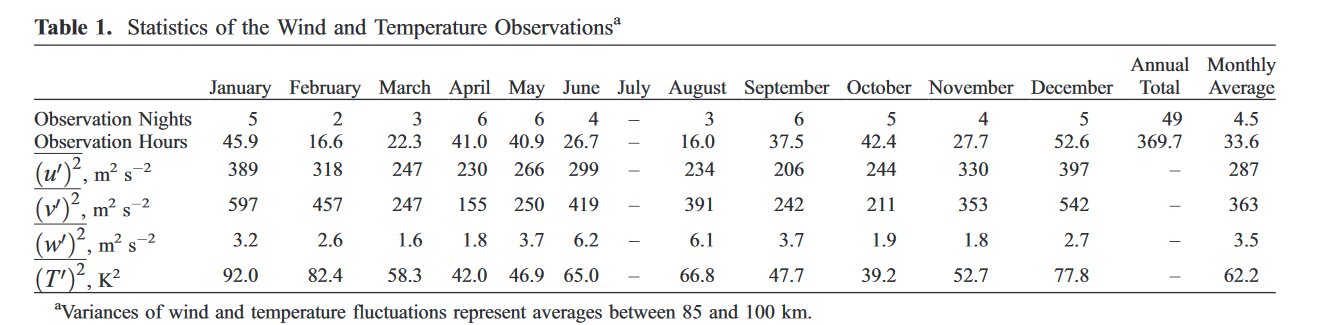